<a href="https://colab.research.google.com/github/ramialnajdi/Marketing-A-B-Testing/blob/main/Marketing_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Marketing A/B Testing project**

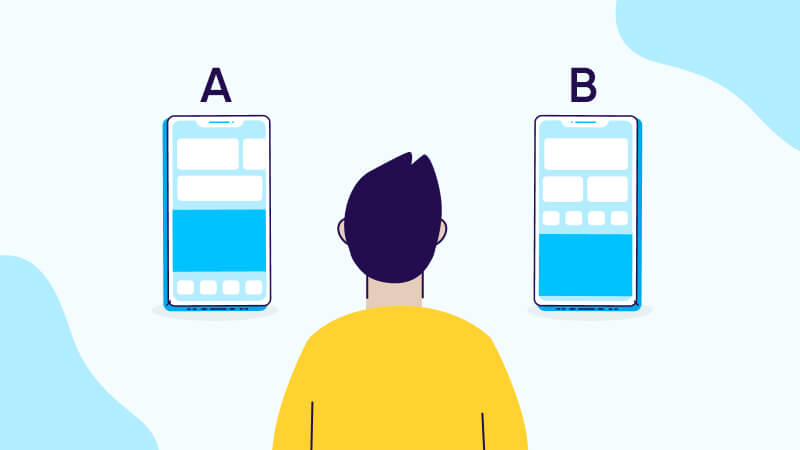

**About Dataset**

**Marketing A/B testing dataset**

Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they run A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

Here is the description about the dataset. You can find more detials in this [link](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data)

| Column         | Description                                                                                     |
|----------------|-------------------------------------------------------------------------------------------------|
| **Index**      | Row index                                                                                       |
| **user id**    | User ID (unique)                                                                                |
| **test group** | Indicates if the person saw the advertisement ("ad") or the public service announcement ("psa") |
| **converted**  | `True` if the person bought the product, otherwise `False`                                      |
| **total ads**  | Number of ads seen by the person                                                                |
| **most ads day** | Day on which the person saw the largest number of ads                                        |
| **most ads hour** | Hour of the day when the person saw the largest number of ads                               |


In [2]:
# Fetch the dataset form kaggle using kagglehub api
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")
file_path = path + '/' + os.listdir(path)[0]

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import zt_ind_solve_power
from scipy.stats import chi2_contingency
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Fetch the dataset as pandas dataframe
data = pd.read_csv(file_path, index_col=0)
data

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


In [5]:
# Change columns' names
data.rename(columns={col_name: col_name.replace(' ', '_') for col_name in data.columns}, inplace=True)

In [6]:
# Diplay info about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [7]:
# Check if there are duplicates
data.duplicated('user_id').sum()

0

In [8]:
# Show categories each categorical data
cate_data = data.drop(['user_id', 'total_ads'], axis=1)
for col in cate_data.columns:
    print(col, ' : ', data[col].unique())

test_group  :  ['ad' 'psa']
converted  :  [False  True]
most_ads_day  :  ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
most_ads_hour  :  [20 22 18 10 14 13 19 11 12 16 21  3 23  4  8  0  2 15  1  6 17  7  9  5]


In [9]:
def barplot_display(data: pd.DataFrame, column: str, annot: bool = True, figsize: tuple = (10, 5), rotation: float = 0) -> None:
    """
    Generates a bar plot displaying the distribution of values in a specified column of a DataFrame,
    with optional annotations showing counts and percentages.

    Parameters:
    -----------
    data : pd.DataFrame
        The DataFrame containing the data to be visualized.

    column : str
        The name of the column to plot. This column should contain categorical values, as it will
        be counted and displayed as a bar chart.

    annot : bool, optional, default=True
        If True, adds annotations on each bar showing both the count and the percentage of the
        total observations for each category.

    figsize: tuple, optional, defaul=(10, 5)
        To detect the dimensions or size of the plot (length, width).

    rotation: float, optional, defaul=0
        To rotate the numbers that will be written above bars.

    Returns:
    --------
    None
        Displays a bar plot with optional annotations. This function does not return any values.
    """
    # Show test group column distribution
    import colorcet as cc
    colors = cc.glasbey_light[:data[column].nunique()]
    ax = data[column].value_counts().plot(kind='bar', figsize=figsize, color=colors)

    # Adding annotations
    if annot:
        for p in ax.patches:
            percentage = p.get_height() / data.shape[0] * 100
            ax.annotate(f'{p.get_height()} - {percentage: .02f}%',
                        (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontweight='bold',
                        fontsize=7.5, rotation=rotation)

    plt.title(f'{column} Distribution')
    plt.xlabel(f'{column}')
    plt.ylabel('frequency')
    plt.show()

## **Univariate Analysis**

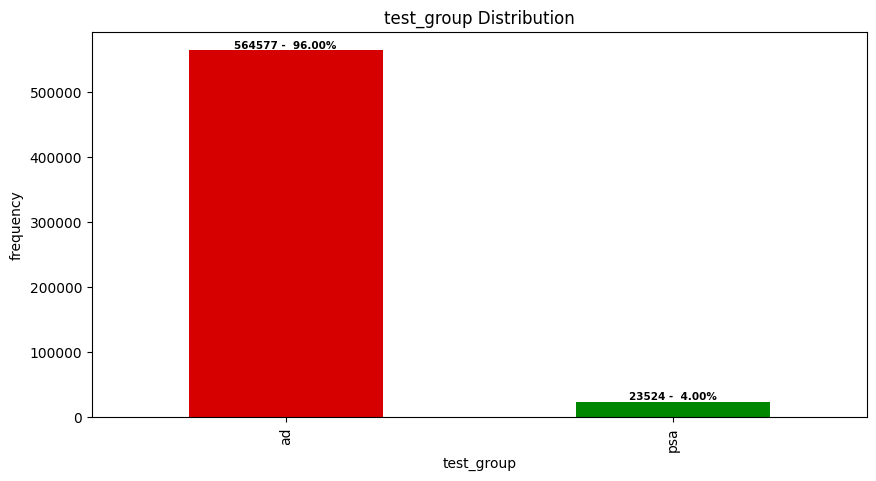

In [10]:
# Display test_group distribution
barplot_display(data, 'test_group')

The chart illustrates the distribution of users in the A/B test groups. The Ad Group represents the vast majority, with 564,577 users (96%) exposed to advertisements, while the PSA Group consists of 23,524 users (4%) shown a public service announcement as a control. This significant imbalance ensures ample data on ad performance but limits control data. The large Ad Group allows for a robust analysis of ad-driven behavior, while the PSA Group provides a baseline for measuring the ads' impact.

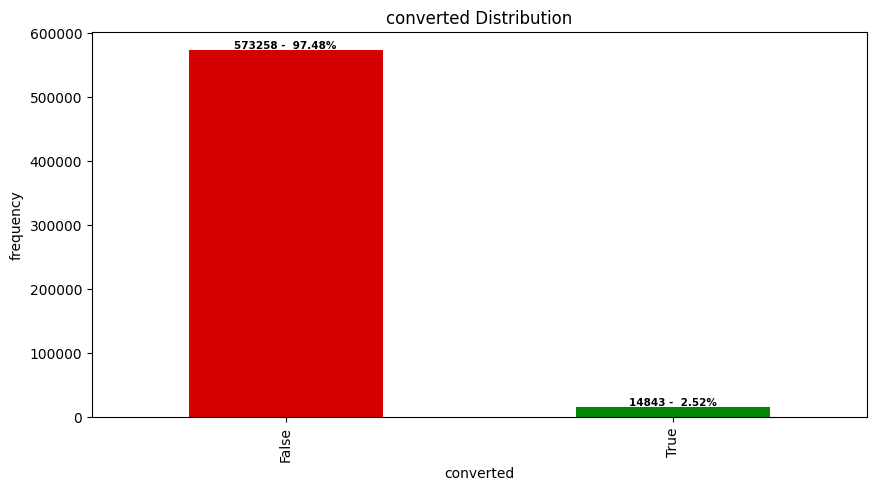

In [11]:
# Display converted distribution
barplot_display(data, 'converted')

The chart shows the conversion rate, with users grouped by whether they converted (made a purchase) or not. The majority of users, 573,258 (97.48%), did not convert, while only 14,843 (2.52%) did.

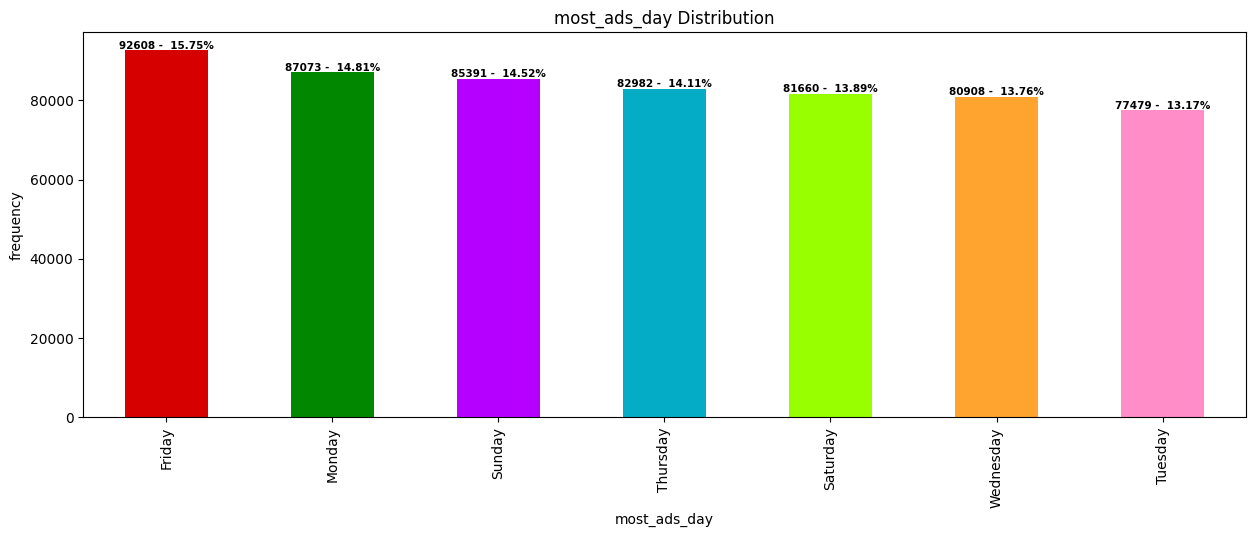

In [12]:
# Display most_ads_day distribution
barplot_display(data, "most_ads_day", figsize=(15, 5))

The bar chart illustrates the distribution of the variable most_ads_day, showing the day of the week on which users saw the most advertisements. Friday has the highest frequency, with 92,608 occurrences (15.75%), followed by Monday and Sunday at 87,073 (14.81%) and 85,391 (14.52%), respectively. The other days are relatively similar in distribution, with Thursday at 82,982 (14.11%), Saturday at 81,660 (13.89%), Wednesday at 80,908 (13.76%), and Tuesday at 77,479 (13.17%). Overall, the distribution is fairly even across the week, with a slight peak on Friday, suggesting consistent ad exposure throughout the week with minimal variation driven by user behavior or campaign scheduling patterns.



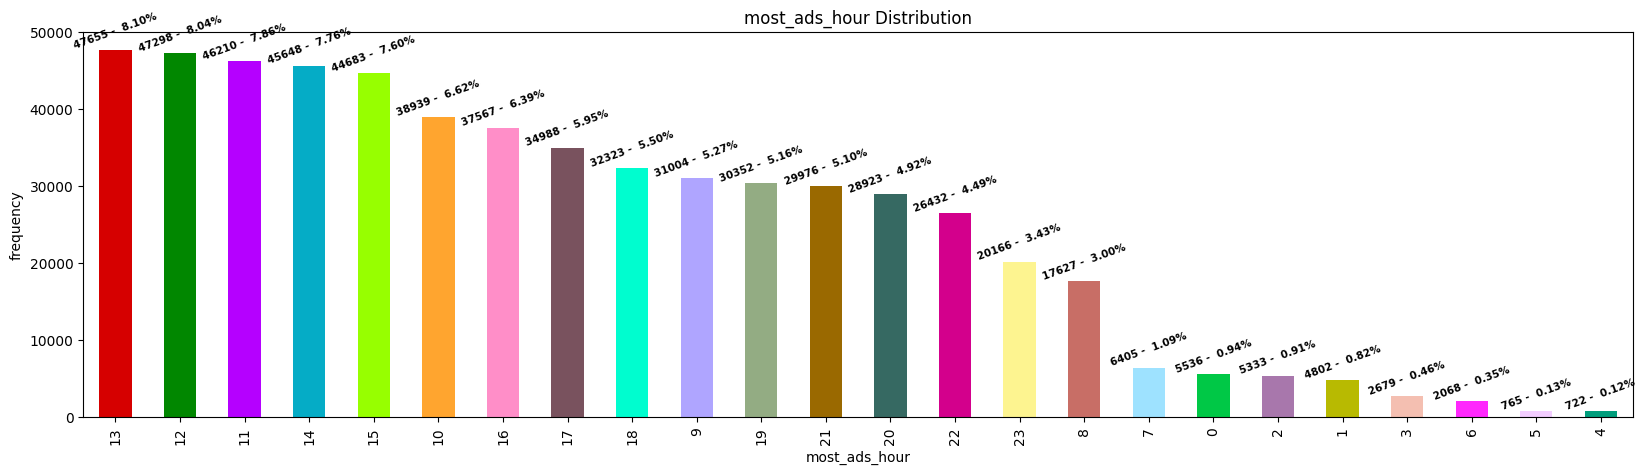

In [13]:
# Display most_ads_hour distribution
barplot_display(data, 'most_ads_hour', figsize=(20, 5), rotation=20)

The chart illustrates the distribution of user activity by the hour of the day when the maximum number of ads were seen (most_ads_hour). The data reveals a unimodal pattern, with peak activity observed during early afternoon hours (13:00) at 47,655 users, followed closely by 12:00 and 11:00, indicating a high engagement period between late morning and early afternoon. Activity declines gradually post-14:00, with significantly lower engagement during late evening (post-22:00) and early morning hours (midnight to 6:00), where the counts drop below 6,000 users. This pattern underscores the importance of targeting ad campaigns during high-activity periods (10:00–15:00) for maximum reach.

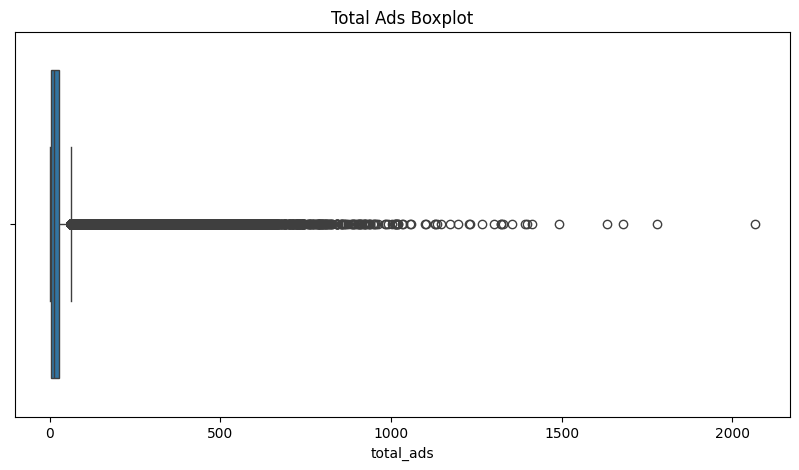

In [14]:
# Display Boxplot for total_ads column to show outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='total_ads')

plt.title('Total Ads Boxplot')
plt.show()

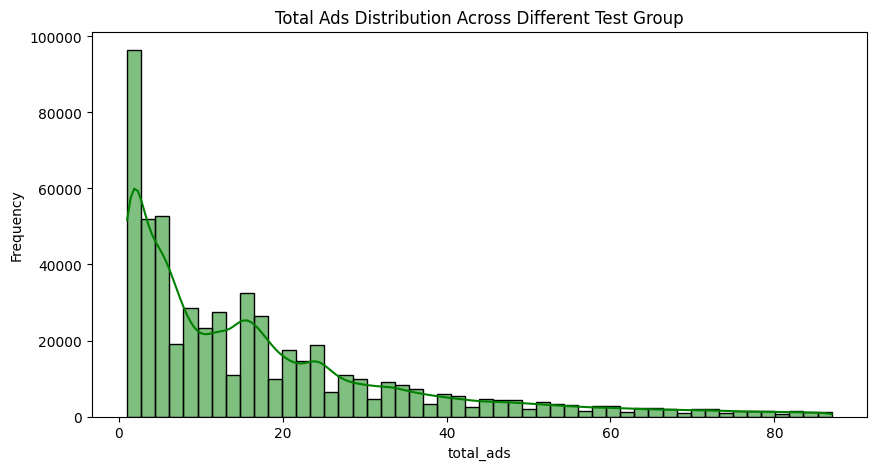

In [15]:
# Remove outliers from total ads column
quantile_95 = data['total_ads'].quantile(0.95)
filtered_data = data[data['total_ads']<quantile_95]

# Plot the histogram
plt.figure(figsize=(10, 5))
sns.histplot(filtered_data, x='total_ads', bins=50, kde=True, color='green')
plt.title('Total Ads Distribution Across Different Test Group')
plt.ylabel('Frequency')
plt.show()

In [16]:
total_ads_summary = data[['total_ads']].describe()
total_ads_summary.loc['skew'] = data['total_ads'].skew()
total_ads_summary.T

,count,mean,std,min,25%,50%,75%,max,skew
total_ads,588101.0,24.820876,43.715181,1.0,4.0,13.0,27.0,2065.0,7.433113


**Total Ads Descriptive Statistics Summary**
* The mean is approximately 25 ads seen per user.
* The high standard deviation relative to the mean confirms significant variability in ad exposure.
* With a skewness of 7.43, this data is extremely right-skewed. Most users are seeing a relatively low to moderate number of ads, while a small group is exposed to an exceptionally high number (up to 2,065 ads).
* The max value (2065.0) is an outlier and far exceeds the 75th percentile. This extreme exposure may reflect certain user behaviors, such as frequent app usage or site visits. However, it could also indicate potential over-exposure.


## **Bivariate Analysis**

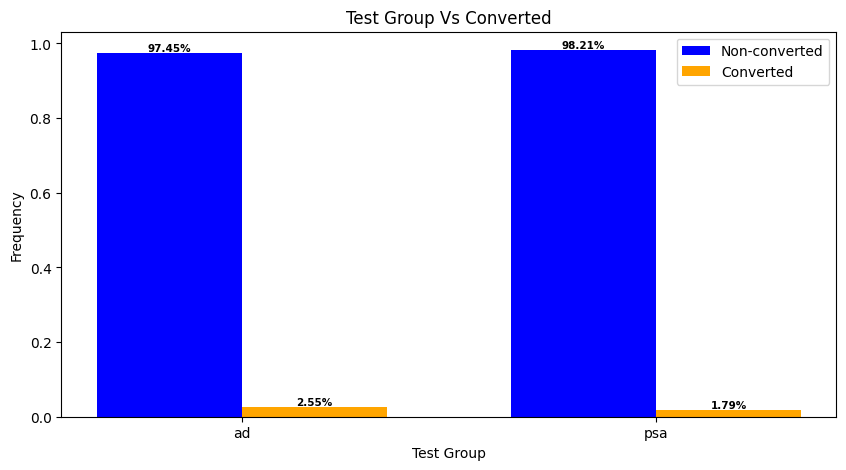

In [17]:
# Display Test Group Vs Converted
crosstab = pd.crosstab(data['test_group'], data['converted'], normalize='index')
categories = crosstab.index
values1 = crosstab.loc[:, False]
values2 = crosstab.loc[:, True]

# Bar width and positioning
bar_width = 0.35
index = np.arange(len(categories))

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(10, 5))
bar1 = ax.bar(index, values1, bar_width, label='Non-converted', color='blue')
bar2 = ax.bar(index + bar_width, values2, bar_width, label='Converted', color='orange')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.02f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontweight='bold',
                fontsize=7.5)

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Test Group')
ax.set_ylabel('Frequency')
ax.set_title('Test Group Vs Converted')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()
plt.show()

The stacked bar chart compares the conversion rates between two test groups:
* users exposed to an advertisement ("ad")
* those shown only a public service announcement ("psa").

 The chart shows that the vast majority of users in both groups did not convert, with 97.45% non-converted in the "ad" group and 98.21% non-converted in the "psa" group. The conversion rate for each group remains low, with only 2.55% of users in the "ad" group converting, compared to 1.79% in the "psa" group. This suggests a slight increase in conversions among users who saw the ad compared to those who only saw the PSA.

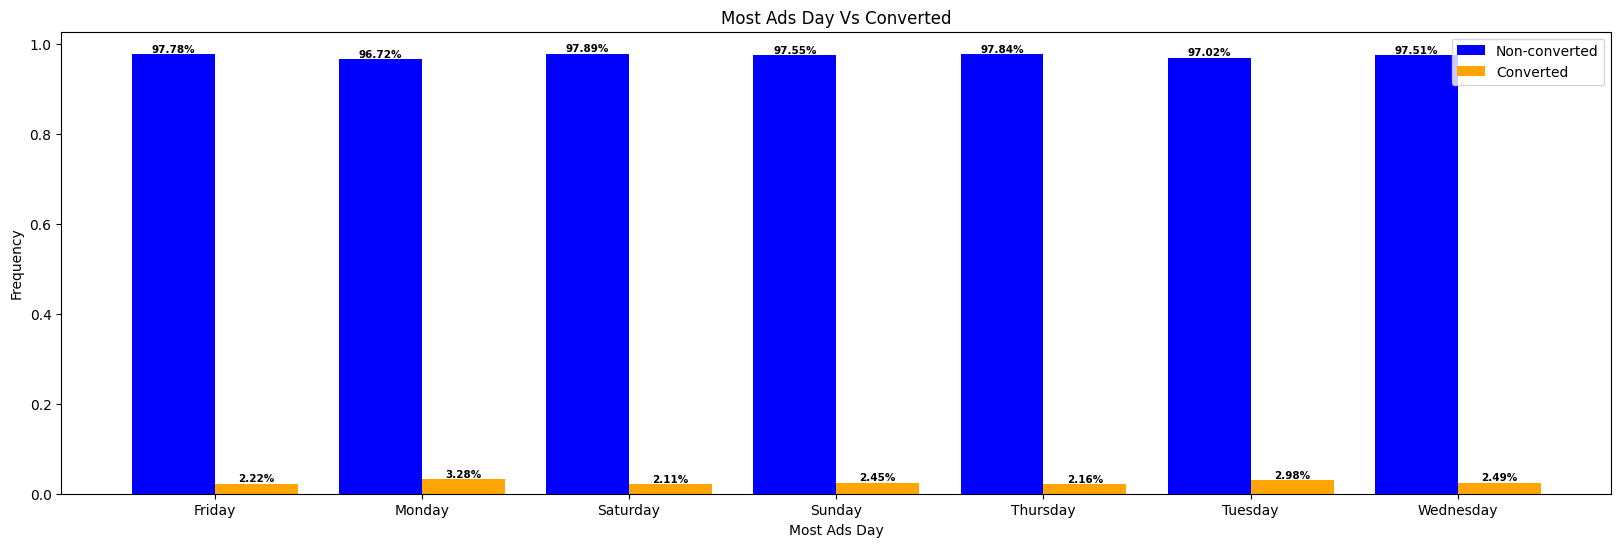

In [18]:
# Display Most Ads Day Vs Converted
crosstab = pd.crosstab(data['most_ads_day'], data['converted'], normalize='index')
categories = crosstab.index
values1 = crosstab.loc[:, False]
values2 = crosstab.loc[:, True]

# Bar width and positioning
bar_width = 0.4
index = np.arange(len(categories))

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(20, 6))
bar1 = ax.bar(index, values1, bar_width, label='Non-converted', color='blue')
bar2 = ax.bar(index + bar_width, values2, bar_width, label='Converted', color='orange')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.02f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontweight='bold',
                fontsize=7.5)


ax.set_xlabel('Most Ads Day')
ax.set_ylabel('Frequency')
ax.set_title('Most Ads Day Vs Converted')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

The stacked bar chart illustrates the conversion rate relative to the day on which users saw the highest number of ads. Each bar represents a specific day of the week, with the distribution between Non-converted (in blue) and Converted (in orange) displayed as a proportion of the total users for that day.

The data shows a consistently high percentage of non-conversions across all days, with Non-converted percentages ranging from 96.72% on Monday to 97.89% on Saturday. The Converted group remains comparatively low, with the highest conversion rate on Monday at 3.28% and the lowest on Saturday at 2.11%.

These findings suggest that conversion rates do not vary significantly by day, and non-conversion remains the dominant outcome across all days, indicating minimal day-specific impact on the likelihood of conversion. The uniformity of non-conversion rates across days might suggest that other factors, rather than the day of ad exposure, are more influential in driving user conversion.

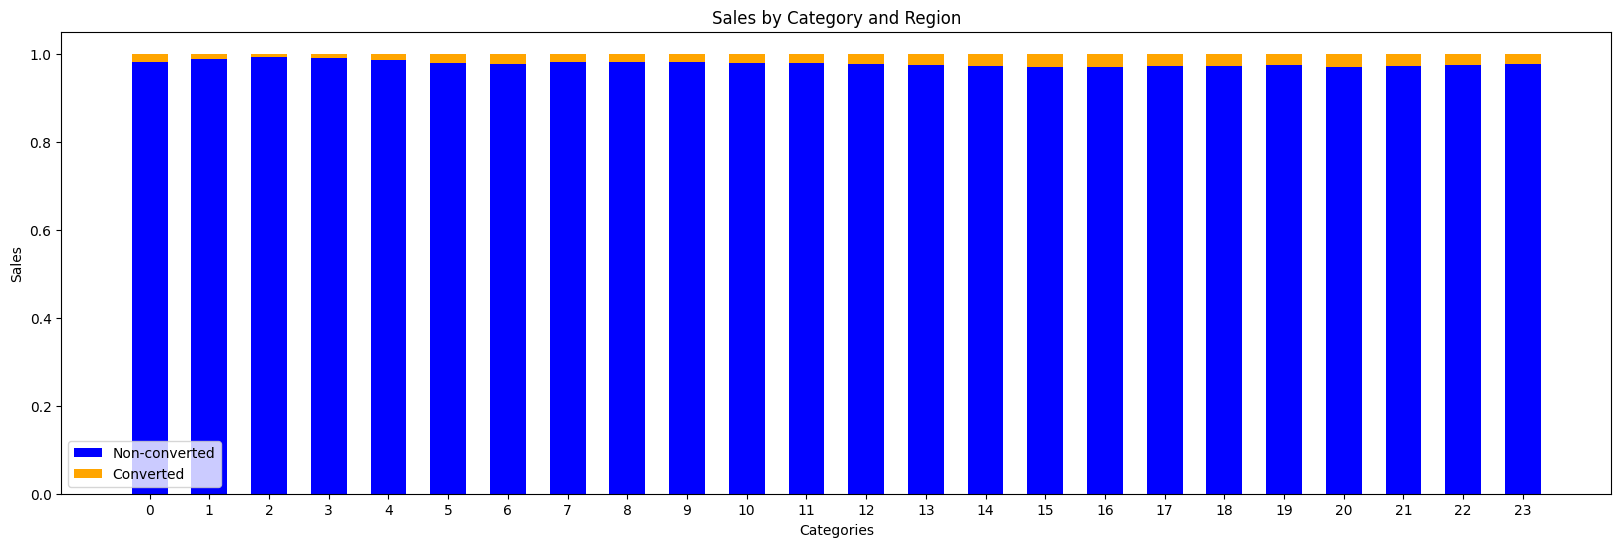

In [19]:
# Display Most Ads Hour Vs Converted
crosstab = pd.crosstab(data['most_ads_hour'], data['converted'], normalize='index')
categories = crosstab.index
values1 = crosstab.loc[:, False]
values2 = crosstab.loc[:, True]

# Define bar width
bar_width = 0.6

# Position of each bar on the x-axis
x = np.arange(len(categories))

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(x, values1, color='blue', width=bar_width, label='Non-converted')
plt.bar(x, values2, bottom=values1, color='orange', width=bar_width, label='Converted')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Sales')
plt.title('Sales by Category and Region')
plt.xticks(x, categories)
plt.legend()
plt.show()

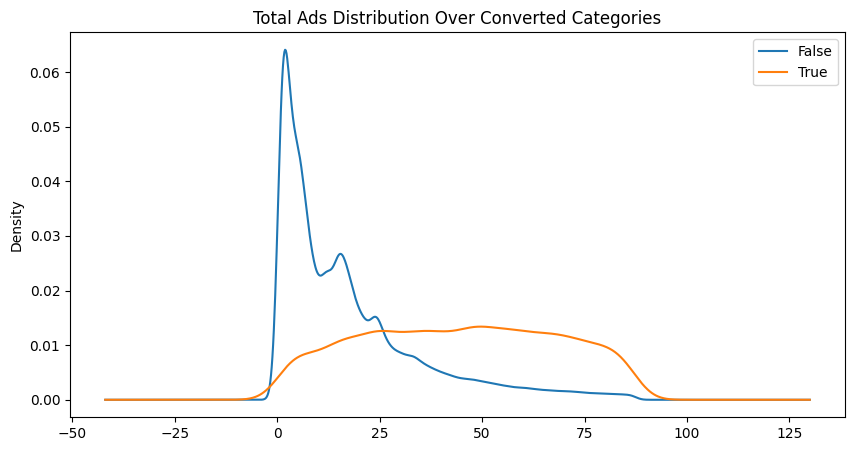

In [20]:
filtered_data.groupby('converted')['total_ads'].plot(kind='kde', legend=True, figsize=(10, 5), title="Total Ads Distribution Over Converted Categories")
plt.show()

## **Hypothesis Testing**

In [23]:
def chi2_test(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Perform a Chi-Square test of independence between a categorical column
    and the 'converted' column.

    Parameters:
    ----------
    df : pd.DataFrame
        Input DataFrame containing the data.
    col : str
        Name of the categorical column to test against 'converted'.

    Returns:
    -------
    pd.DataFrame
        A DataFrame with:
        - "Chi-Square Statistic": Test statistic.
        - "P-value": Significance level.
        - "Degrees of Freedom": Number of degrees of freedom.
        - "Expected Frequencies": Expected frequencies under the null hypothesis.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(df[col], df['converted'])

    # Perform Chi-Square test
    chi2, p_value, dof, _ = chi2_contingency(contingency_table)

    return pd.DataFrame(
        {
         "Chi-Square Statistic": chi2,
         "P-value": p_value,
         "Degrees of Freedom": dof,
        },
        index=['results']
    )


**Testing for a Relationship Between Test Group and Conversion Status**

**Null Hypothesis (H₀):**  
There is no relationship between the test group and the conversion status (i.e., they are independent).

**Alternative Hypothesis (H₁):**  
There is a relationship between the test group and the conversion status (i.e., they are not independent).

The Chi-Square test will be used to determine whether a relationship exists between the test group and conversion status.


In [24]:
chi2_test(data, 'test_group')

,Chi-Square Statistic,P-value,Degrees of Freedom
results,54.005824,1.998962e-13,1


**Report: Testing the Relationship Between Test Group and Conversion Status**

A Chi-Square test was conducted to evaluate the relationship between the test group (ad or psa) and conversion status. The null hypothesis
 (H₀) stated that there is no relationship between these variables, implying independence. The test yielded a Chi-Square statistic of 54.0058 with 1 degree of freedom and a p-value of **1.998 * 10^-13**, which is significantly below the standard significance level of 0.05. This result provides strong evidence to reject the null hypothesis. Therefore, we conclude that there is a statistically significant relationship between the test group and conversion status. These findings suggest that the type of test group is associated with conversion outcomes and may influence user behavior. Further analysis could explore the nature and strength of this association.


**Testing for a Relationship Between Most Ads Day and Conversion Status**

**Null Hypothesis (H₀):**  
There is no relationship between the most ads day and the conversion status (i.e., they are independent).

**Alternative Hypothesis (H₁):**  
There is a relationship between the most ads day and the conversion status (i.e., they are not independent).

The Chi-Square test will be used to determine whether a relationship exists between the most ads day and conversion status.


In [25]:
chi2_test(data, 'most_ads_day')

,Chi-Square Statistic,P-value,Degrees of Freedom
results,410.047886,1.932184e-85,6


**Report: Relationship Between Most Ads Day and Conversion Status**

A Chi-Square Test of Independence was conducted to evaluate the relationship between the day users saw the most ads (`most ads day`) and their conversion status. The results showed a significant Chi-Square statistic of **410.048** p-value **1.93 * 10^-85**, degrees of freedom = 6, indicating a strong relationship between these variables. This provides robust evidence that conversion likelihood is influenced by the specific day users encounter the most ads. These findings suggest that ad campaigns could benefit from strategic scheduling on days with higher conversion potential, optimizing engagement and overall effectiveness.


**Testing for a Relationship Between Most Ads Hour and Conversion Status**

**Null Hypothesis (H₀):**  
There is no relationship between the most ads hour and the conversion status (i.e., they are independent).

**Alternative Hypothesis (H₁):**  
There is a relationship between the most ads hour and the conversion status (i.e., they are not independent).

The Chi-Square test will be used to determine whether a relationship exists between the most ads hour and conversion status.

In [26]:
chi2_test(data, 'most_ads_hour')

,Chi-Square Statistic,P-value,Degrees of Freedom
results,430.768692,8.027630e-77,23


**Report: Relationship Between Most Ads Hour and Conversion Status**

A Chi-Square Test of Independence was conducted to examine the relationship between the hour of the day users saw the most ads (`most ads hour`) and their conversion status. The test yielded a Chi-Square statistic of **430.769** with **23 degrees of freedom** and a p-value of 8.03 * 10^-77. The extremely low p-value indicates that the null hypothesis can be rejected, providing strong statistical evidence of a significant relationship between the most ads hour and conversion status. This suggests that the time of day when users see the highest number of ads influences their likelihood of converting, highlighting the importance of identifying optimal hours for ad delivery to maximize conversions.


**Testing for a Relationship Between Total Ads and Conversion Status**

**Null Hypothesis (H₀):**

There is no significant difference in the mean number of ads seen between the converted and non-converted groups.

**Alternative Hypothesis (H₁):**

 There is a significant difference in the mean number of ads seen between the converted and non-converted groups.

In [27]:
# Split data into converted and non-converted groups
group_converted = data[data['converted'] == True]['total_ads']
group_non_converted = data[data['converted'] == False]['total_ads']

# Test for normality
normality_converted = shapiro(group_converted)
normality_non_converted = shapiro(group_non_converted)
print("Shapiro-Wilk Test For Normality test:")
print(f"Converted group p-value: {normality_converted.pvalue}")
print(f"Non-converted group p-value: {normality_non_converted.pvalue}")

# Test for equality of variances
variance_test = levene(group_converted, group_non_converted)
print("\nLevene's Test for Equality of Variances:")
print(f"P-value: {variance_test.pvalue}")

# Perform t-test
print("\nData is normal. Performing t-test:")
equal_var = variance_test.pvalue > 0.05
t_test = ttest_ind(group_converted, group_non_converted, equal_var=equal_var)
print(f"T-test statistic: {t_test.statistic}, p-value: {t_test.pvalue}")

# Perform  Mann-Whitney U test
print("\nData is not normal. Performing Mann-Whitney U test:")
mann_whitney = mannwhitneyu(group_converted, group_non_converted, alternative='two-sided')
print(f"Mann-Whitney U test statistic: {mann_whitney.statistic}, p-value: {mann_whitney.pvalue}")

Shapiro-Wilk Test For Normality test:
Converted group p-value: 1.638680987007771e-98
Non-converted group p-value: 9.883049430735801e-204

Levene's Test for Equality of Variances:
P-value: 0.0

Data is normal. Performing t-test:
T-test statistic: 84.17740664633055, p-value: 0.0

Data is not normal. Performing Mann-Whitney U test:
Mann-Whitney U test statistic: 7269106736.0, p-value: 0.0


**Report: Relationship Between Total Ads and Conversion Status**

The analysis aimed to determine whether there is a significant difference in the mean number of ads seen between users who converted and those who did not.

**Tests and Results:**

1. **Shapiro-Wilk Test for Normality**:
   - **Converted group p-value**: 0.0
   - **Non-converted group p-value**: 0.0  
   Both groups fail the normality test (p-value < 0.05), indicating that the data is **not normally distributed**.

2. **Levene's Test for Equality of Variances**:
   - **Levene's p-value**: 0.0  
   This result indicates that the variances between the two groups are significantly different, suggesting unequal variances.

3. **T-test (For Normally Distributed Data)**:
   - **T-test statistic**: 84.18
   - **T-test p-value**: 0.0  
   The T-test results are **not applicable** due to the non-normality of the data, as it assumes normality.

4. **Mann-Whitney U Test (Non-parametric Test)**:
   - **Mann-Whitney U test statistic**: 7,267,106,736.0
   - **Mann-Whitney U p-value**: 0.0  
   The Mann-Whitney U test, which does not require the assumption of normality, shows a statistically significant difference between the two groups (p-value = 0.0).

**Conclusion:**

The **Mann-Whitney U test** reveals a significant difference in the distribution of the number of ads seen between the converted and non-converted groups (p-value = 0.0). Therefore, we **reject the null hypothesis** and conclude that the number of ads seen is significantly different between users who converted and those who did not, suggesting that ad exposure may influence conversion behavior.

## **A/B Testing**

**Calculate the sample size required for conducting an A/B test**

In [28]:
# Get converted ad ratio and converted psa ratio from the dataset
converted_ad_ratio, converted_psa_ratio = pd.crosstab(data['test_group'], data['converted'], normalize='index').loc[:, True].to_list()

# Define parameters
baseline_rate = converted_psa_ratio                             # baseline conversion rate
effect_size = converted_ad_ratio - converted_psa_ratio          # Minimum Detectable Effect
alpha = 0.05                                                    # Significance level
power = 1                                                       # Desired power

# Calculate sample size
sample_size_per_group = zt_ind_solve_power(
    effect_size=(effect_size / baseline_rate),  # Effect size as a proportion
    alpha=alpha,
    power=power,
    alternative='two-sided'
)

print(f"Required sample size per group: {sample_size_per_group:.0f}")

Required sample size per group: 5000


 The required sample size per group is 5000, it means that for a typical A/B test with two groups (control and treatment), you need 5000 participants in each group, totaling 10,000 participants for the test.

**Hypotheses for A/B Testing**

- **Null Hypothesis (H₀):** The type of advertisement (ad vs. psa) does not affect the conversion rate.
- **Alternative Hypothesis (H₁):** The type of advertisement has an effect on the conversion rate.


In [29]:
# Group data by test group and converted to get conversion counts
conversion_counts = data.groupby('test_group')['converted'].agg(['sum', 'count'])

# Extract values for ad and psa groups
ad_conversions = conversion_counts.loc['ad', 'sum']
psa_conversions = conversion_counts.loc['psa', 'sum']
ad_total = conversion_counts.loc['ad', 'count']
psa_total = conversion_counts.loc['psa', 'count']

# Counts of conversions in each group
conversion_counts = [ad_conversions, psa_conversions]

# Total users in each group
total_counts = [ad_total, psa_total]

# Perform the two-proportion z-test
z_stat, p_value = proportions_ztest(conversion_counts, total_counts)

print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

Z-statistic: 7.3700781265454145
P-value: 1.7052807161559727e-13


**Report: Hypotheses for A/B Testing**

A **two-proportion z-test** was conducted to assess whether the type of advertisement (ad vs. psa) affects the conversion rate.

**Results:**

- **z-statistic**: 7.37
- **p-value**: 1.71 * 10^-13

**Interpretation:**

The **z-statistic** of 7.37 is significantly larger than typical critical values (e.g., ±1.96 for a 95% confidence level). The **p-value** of 1.71 * 10^-13 is extremely small, well below the common significance threshold of 0.05.

Given the extremely low p-value, we **reject the null hypothesis (H₀)**. This provides strong evidence that the type of advertisement (ad vs. psa) **does** have a statistically significant effect on the conversion rate.

This suggests that the choice of advertisement type has a meaningful impact on user conversions, and further investigation into which type is more effective may be warranted.


# **Comprehensive Data-Driven Analysis Summary**

## **Data Insights**

1. **Test Group Distribution**:
   - The Ad Group dominates (**96% of users**), ensuring robust data on ad performance.
   - The PSA Group (**4% of users**) provides a control, albeit with limited statistical power due to smaller sample size.

2. **Conversion Metrics**:
   - Conversion rates are low overall: **2.55% for the Ad Group** vs. **1.79% for the PSA Group**.
   - This indicates that advertisements have a small but statistically significant positive effect on conversion rates.

3. **Temporal Analysis**:
   - **Most Ads Day**: Ads are distributed fairly evenly throughout the week, with a slight peak on **Friday (15.75%)**.
   - **Most Ads Hour**: Peak ad exposure occurs between **10:00 and 15:00**, highlighting optimal hours for targeting.

4. **Ad Exposure (Total Ads)**:
   - The data is right-skewed, with most users seeing a moderate number of ads, while a few see an extreme number (up to **2,065 ads**).
   - Significant differences in ad exposure exist between converted and non-converted users, suggesting the importance of optimizing ad delivery.

---

## **Statistical Testing**

1. **Test Group and Conversion Status**:
   - **Chi-Square Test** reveals a significant relationship (\(p < 0.05\)), indicating that test group type (Ad vs. PSA) influences conversion rates.

2. **Most Ads Day and Conversion**:
   - Significant Chi-Square statistic suggests the day of ad exposure impacts conversion, although differences across days are minimal.

3. **Most Ads Hour and Conversion**:
   - The hour of maximum ad exposure significantly affects conversion likelihood. Afternoon hours (**11:00–14:00**) show peak effectiveness.

4. **Total Ads and Conversion**:
   - **Mann-Whitney U Test** confirms significant differences in ad exposure between converted and non-converted users (\(p = 0.0\)).
   - Tailoring ad exposure thresholds could optimize conversion rates.

5. **A/B Testing**:
   - The **two-proportion z-test** confirms a statistically significant difference in conversion rates between the Ad and PSA groups (\(z = 7.37, p < 0.05\)).
   - Required sample size per group: **5,000 users** for robust A/B testing.



### **Data-Driven Recommendations for Managers**

Based on the data analysis, here are actionable recommendations tailored for management decision-making:

---

#### **1. Reallocate Resources Towards High-Performing Strategies**
- **Insight**: Advertisements (Ad Group) achieve a higher conversion rate (**2.55%**) compared to public service announcements (PSA Group, **1.79%**).
- **Recommendation**:
  - Invest more heavily in advertisement-driven campaigns while maintaining PSA campaigns as a control for ongoing evaluation.
  - Explore ad types and messaging strategies to further boost conversions.

---

#### **2. Focus on Optimal Engagement Periods**
- **Insight**: Peak user activity occurs during **10:00–15:00**, with a significant drop during late evenings and early mornings.
- **Recommendation**:
  - Schedule ad campaigns during high-engagement periods to maximize ROI.
  - Reduce spending on ad placements during off-peak hours to optimize the budget.

---

#### **3. Address Conversion Challenges**
- **Insight**: Despite high ad exposure, the overall conversion rate remains low at **2.52%**.
- **Recommendation**:
  - Evaluate user behavior post-ad exposure to identify barriers to conversion (e.g., poor landing page design, unclear calls-to-action).
  - A/B test creative ad variations to pinpoint factors that drive higher conversions.

---

#### **4. Limit Over-Exposure to Ads**
- **Insight**: Outliers are exposed to an exceptionally high number of ads (up to 2,065), potentially leading to ad fatigue.
- **Recommendation**:
  - Cap ad impressions per user to balance visibility with effectiveness.
  - Implement frequency capping tools to prevent oversaturation and improve user experience.

---

#### **5. Refine Campaign Scheduling by Day**
- **Insight**: Conversion rates and ad engagement show slight variability by day, with **Monday (3.28%)** having the highest conversion rate and **Saturday (2.11%)** the lowest.
- **Recommendation**:
  - Prioritize ad spending on high-conversion days (e.g., Monday and Friday).
  - Reassess Saturday campaigns to understand and address underperformance.

---

#### **6. Expand PSA Sample for Better Insights**
- **Insight**: The PSA Group constitutes only **4%** of users, limiting control group insights.
- **Recommendation**:
  - Increase the PSA sample size for future campaigns to enable more robust comparisons.
  - Ensure experimental designs have more balanced group sizes to yield reliable insights.

---

#### **7. Empower Teams with Continuous A/B Testing**
- **Insight**: The A/B test showed significant differences between groups, but further refinement is needed.
- **Recommendation**:
  - Institutionalize A/B testing as a core practice for evaluating all future campaigns.
  - Use the calculated **sample size of 5,000 users per group** to ensure statistically valid results.

---

#### **8. Monitor and Adjust Strategies**
- **Insight**: Ads scheduled on peak engagement days (e.g., Friday, Monday) and times (10:00–15:00) influence conversions significantly.
- **Recommendation**:
  - Assign marketing teams to monitor and analyze campaign performance metrics weekly.
  - Adjust campaign parameters dynamically based on real-time user engagement data.

---

By implementing these recommendations, managers can enhance campaign effectiveness, optimize ad spending, and drive higher conversion rates while maintaining a balanced, data-driven approach to strategic decision-making.
